# Cross-correlation of background seismic noise for Green's function retrieval

<img width=150px src="https://upload.wikimedia.org/wikipedia/fr/thumb/1/16/Institut_de_physique_du_globe_de_paris_logo.svg/1200px-Institut_de_physique_du_globe_de_paris_logo.svg.png" />

_This notebook is inspired from the available online notebook [Ambient Seismic Noise Analysis](https://krischer.github.io/seismo_live_build/html/Ambient%20Seismic%20Noise/NoiseCorrelation.html) originally created by Celine Hadziioannou and Ashim Rijal. The original version of the notebook was modified by Léonard Seydoux (seydoux@ipgp.fr) in 2023 for the course "Scientific Computing for Geophysical Problems" at the [institut de physique du globe de Paris](http://www.ipgp.fr). It now includes a synthetic part to inspect the influence of the source distribution on the cross-correlation functions._ 

## Table of contents

1. [Introduction](#1.-Introduction)
    1. [Goals of this notebook](#1.1.-Goals-of-this-notebook)
    2. [Requirements](#1.2.-Requirements)
    3. [Theoretical background](#1.3.-Theoretical-background)
2. [Numerical experiments](#2.-Numerical-experiments)
    1. [Experimental setup](#2.1.-Experimental-setup)
    2. [Generation of the synthetic seismograms](#2.2.-Generation-of-the-synthetic-seismograms)
    3. [Cross-correlation of the synthetic seismograms](#2.3.-Cross-correlation-of-the-synthetic-seismograms)
    4. [Cross-correlation of the synthetic seismograms for different azimuths](#2.4.-Cross-correlation-of-the-synthetic-seismograms-for-different-azimuths)
    5. [Mixture of all sources](#2.5.-Mixture-of-all-sources)
    6. [Getting rid of cross terms](#2.6.-Getting-rid-of-cross-terms)
3. [Application to real data](#3.-Application-to-real-data)
    1. [Data download](#3.1.-Data-download)
    2. [Data inspection](#3.2.-Data-inspection)
    3. [Data processing](#3.3.-Data-processing)
    4. [Cross-correlation of the data](#3.4.-Cross-correlation-of-the-data)
    5. [Comparison of the cross-correlation with an earthquake](#3.5.-Comparison-of-the-cross-correlation-with-an-earthquake)
4. [Perspectives](#4.-Perspectives)
    

## 1. Introduction

### 1.1. Goals

This Jupyter notebook shows how to turn continuous records of ambient seismic noise into virtual seismograms using the theory of cross-correlation. The goal of this notebook is to reproduce part of the results obatined in the paper [_High-Resolution Surface-Wave Tomography from Ambient Seismic Noise_, by Shapiro, et al. (2005)](https://www.science.org/doi/10.1126/science.1108339).

### 1.2. Requirements

This notebook relies on Python libraries listed below. If you are running this notebook on the virtual machine provided for the course, you should have all the required libraries installed. If you are running this notebook on your own machine, you will need to install the following libraries:

- [ObsPy](https://github.com/obspy/obspy/wiki), an open-source project that provides a Python framework for processing seismological data. It provides parsers for standard file formats, clients to access data centers, and signal processing routines that allow the manipulation of seismological time series.
- [NumPy](https://numpy.org), an open-source project aiming to enable numerical computing with Python.
- [SciPy](https://numpy.org), fundamental algorithms for scientific computing in Python.
- [Matplotlib](https://matplotlib.org), a comprehensive library for creating static, animated, and interactive visualizations in Python.

If unavailable on your machine, you can use the [Anaconda](https://www.anaconda.com) package manager to install these libraries. Please ensure you can run the following cell without any error before proceeding further.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.clients.fdsn import Client
from scipy import signal
from tqdm.notebook import tqdm

import noise

### 1.3. Theoretical background

Let consider the continuous records $u_1(t)$ and $u_2(t)$ recorded at two stations $1$ and $2$ respectively. The cross-correlation function $C_{12}(\tau)$ is defined as

$$
C_{12}(\tau) = \int_{-\infty}^{+\infty} u_1(t) u_2(t+\tau) dt
$$

where $\tau$ defines the time lag between the two records. Many studies have shown that the cross-correlation function of ambient seismic noise is related to the Green's function between the two stations when the seismic records $u_1(t)$ and $u_2(t)$ consist of __ambient seismic noise__ only, with stastical properties detailed below. In this case, the relation between the cross-correlation function and the Green's function is given by

$$
\dot C_{12}(t) = \alpha(G(x_1, x_2, t) - G(x_2, x_1, -t)),
$$

where $\alpha$ is a constant which depends on the properties of the seismic noise, and the Green's function $G(x_1, x_2, \tau)$ is the solution to the wave equation evaluated in $x_2$ to a spatio-temporal delta source located at $x_1$ at time $t=0$, i.e.

$$
\ddot G(x_1, x, t) - c^2 \nabla^2 G(x_1, x, t) = \delta(x-x_1) \delta(t),
$$

if we assume that the medium is homogeneous and isotropic, in the extremely simplified case of the scalar wave equation. This concept generalizes to more complex media, under other hypotheses. As strongly emphasized above, there are strong assumption where the above equation remains valid. The main assumption is that the seismic noise is __stationary__ and __isotropic__. The first assumption implies that the seismic noise is invariant in time, which is not true in general. The second assumption implies that the seismic noise is invariant in space, which is also not true in general. 

In practice, the cross-correlation function is computed over a finite time window $T$. The cross-correlation function is then defined as

$$
C_{12}(\tau) = \int_{-T/2}^{T/2} u_1(t) u_2(t+\tau) dt.
$$

Note that the cross-correlation function can be computed from the Fourier transform of the two records $\hat u_1(\omega)$ and $\hat u_2(\omega)$ as

$$
C_{12}(\tau) = \mathcal{F}^{-1} \left[ \hat u_1(\omega) \hat u_2^*(\omega) \right],
$$

where $\hat u_2^*(\omega)$ is the complex conjugate of $\hat u_2(\omega)$. We will here use the SciPy function `scipy.signal.correlate` to compute the cross-correlation function, which is based on the Fourier transform.

## 2. Numerical experiments

We will first observe the correlation of ambient seismic noise between two seismic stations, when the seismic noise is generated by a set of sources located at different azimuths, and illustrate the concept of Green's function retrieval from the cross-correlation function.

### 2.1. Experimental setup

The next cell allows to define the seismic experimental setup. First, we define the seismic station coordinates $x_i, y_i$ in the two-dimensional space. For the sake of simplicity, we set the two seismic station on the $x$-axis at 

$$
\begin{align}
x_1 &= -\Delta x/2, \\
x_2 &= \Delta x/2,
\end{align}
$$

with $\Delta x = 500$ km, and keep the $y$-coordinate to zero. The sources are considered to be located infinitely far away from the seismic station, and are defined by their azimuth $\theta$, defined with respect to the $y$-axis. Actually, since we want to check the impact of the azimuthal distribution of the sources on the Green's function retrieval, we define an azimuthal distribution of the amplitude $A(\theta)$. At first, we consider an isotropic distribution, i.e. $A(\theta) = 1$ for all $\theta$.

In the plot below, we represent the seismic station and plot the azimuthal distribution of the sourcces. The plot simply aims at showing a source at a close distance while the sources are actually located infinitely far away from the seismic station.

> __Question 1.__ Modify the code below to consider a single source located at an azimuth $\theta = 90$° with an amplitude $A(\theta) = 1$.

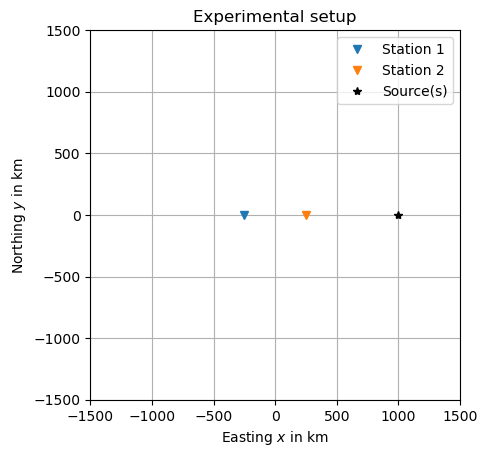

In [2]:
# Define the coordinates of the two stations (in km)
n_stations = 2
inter_station_distance = 500
x_stations = np.linspace(-1, 1, n_stations) * inter_station_distance / 2
y_stations = np.zeros_like(x_stations)

# Define the azimuthal source distribution (in degrees)
n_sources = 1
azimuths = np.linspace(0, 360, n_sources, endpoint=False) + 90
amplitudes = np.ones_like(azimuths)

# Plot the seismic setup
fig, ax = plt.subplots()

# Plot stations
for i, (x, y) in enumerate(zip(x_stations, y_stations)):
    ax.plot(x, y, "v", label=f"Station {i + 1}")

# Plot sources
source_radius = 2 * inter_station_distance
x_sources = np.sin(np.radians(azimuths)) * source_radius
y_sources = np.cos(np.radians(azimuths)) * source_radius
ax.plot(x_sources, y_sources, "k*", label="Source(s)")

# Labels
ax.set_xlabel("Easting $x$ in km")
ax.set_ylabel("Northing $y$ in km")
ax.set_title("Experimental setup")
ax.set_aspect("equal")
ax.set_xlim(-1.5 * source_radius, 1.5 * source_radius)
ax.set_ylim(-1.5 * source_radius, 1.5 * source_radius)
ax.legend()
ax.grid()

# Show
plt.show()

### 2.2. Generation of the synthetic seismograms

Next, we need to generate the synthetic signal emitted by the sources and collect them at the station locations. We here consider the source time function to be a Gaussian random noise with a variance defined by the amplitude of the source. The signals are then filtered with a bandpass filter to keep only the frequencies of interest.

We need to define the duration of the synthetic record $T$, the sampling rate of the seismic sensor $f_s$, and the frequency band of interest $f_\text{min}$ and $f_\text{max}$. The next cell allows to define these parameters. We also consider a seismic velocity of $v = 5$ km/s. We consider here that one of the station records the source signal as it is, while the other station records the signal with a time shift of $\Delta t(\theta)$ in seconds.

> __Question 2.__ Give an analytical expression of the time shift $\Delta t(\theta)$ as a function of the azimuth $\theta$ and the distance between the two seismic stations.

> __Question 3.__ Investigate the `butter` and the `filtfilt` functions of the `scipy.signal` package. How would you use these functions to filter the source signals withing a frequency band of interest? What is the specific feature of the `filtfilt` function, and why is it important in our case? Apply the filter to the source signals $s_k(t)$, where $k = 1 \ldots K$ is the source index.

> __Question 4.__ We consider that station 1 records the source time functions without any shift in time, so that 
> $$u_1(t) = \sum_{k=1}^K s_k(t).$$
> Station 2 records the source time functions with a time shift $\Delta t(\theta_k)$, so that 
> $$u_2(t) = \sum_{k=1}^K s_k(t - \Delta t(\theta_k)).$$
> Write a function that generates the source signals and returns the two station records $u_1(t)$ and $u_2(t)$. Plot the two station records. 

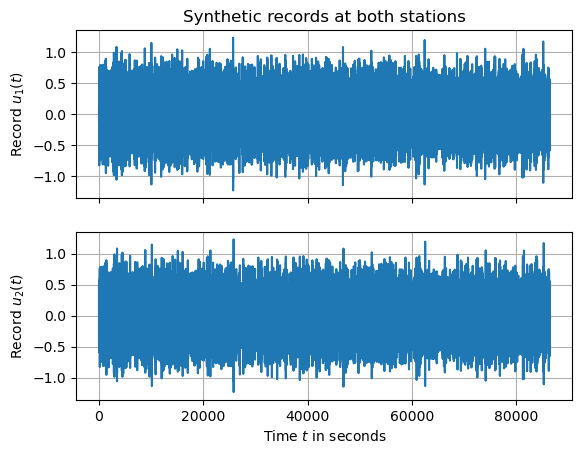

In [3]:
# Parameters (we use the international system of units)
record_duration = 24 * 3600
source_duration = 20
sampling_rate = 1
center_frequency = 0.07
velocity = 5
fmin, fmax = 0.05, 0.1
n_samples = int(record_duration * sampling_rate)

# Create the signal at both stations
source_records = noise.source_time_function(n_sources, n_samples, amplitudes)
times = np.arange(n_samples) / sampling_rate

# Filter the signal
source_records = noise.bandpass(source_records, fmin, fmax, sampling_rate)

# Get signal at both stations.
station_1 = source_records.sum(axis=0)

# Get signal at station 2 by summing the sources with a time delay
station_2 = np.zeros_like(station_1)
for source_record, azimuth in zip(source_records, azimuths):
    projection = np.sin(np.radians(azimuth))
    delay = projection * inter_station_distance / velocity
    station_2 += np.roll(source_record, int(delay * sampling_rate))

# Plot
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(times, station_1)
ax[1].plot(times, station_2)

# Labels
ax[0].set_ylabel("Record $u_1(t)$")
ax[0].set_title("Synthetic records at both stations")
ax[1].set_ylabel("Record $u_2(t)$")
ax[1].set_xlabel("Time $t$ in seconds")
ax[0].grid()
ax[1].grid()

# Show
plt.show()

### 2.3. Cross-correlation of the synthetic seismograms

Now, we consider the cross-correlation of the signals recorded at the two stations. The cross-correlation is defined as

$$C_{12}(\tau) = \int_{-\infty}^{+\infty} u_1(t) u_2(t+\tau) \, \mathrm{d}t,$$

where $\tau$ is the time lag between the two signals. Thanks to the properties of the Fourier transform, the cross-correlation can be computed in the frequency domain as

$$C_{12}(\tau) = \mathcal{F}^{-1}\left\{ \mathcal{F}\left\{u_1(t)\right\} \mathcal{F}\left\{u_2(t)\right\}^* \right\}(\tau),$$

where $\mathcal{F}\left\{u_1(t)\right\}$ and $\mathcal{F}\left\{u_2(t)\right\}$ are the Fourier transforms of the signals $u_1(t)$ and $u_2(t)$, respectively, and $^*$ denotes the complex conjugate. Because of the speed of the Fast Fourier Transform (FFT) algorithm, it is much more efficient to compute the cross-correlation in the frequency domain than in the time domain. This is already implemented in the `scipy.signal.correlate` function, which computes the cross-correlation of two signals. Take time to read the documentation of this function.

In the cell below, we compute the auto-correlation from one of the two station records and the cross-correlation of the two station records. We plot both functions as a function of the time lag $\tau$.

> __Question 5.__ What are the shapes of the auto-correlation and of the cross-correlation functions, and how do they differ? What is the time lag $\tau$ corresponding to the maximum of the cross-correlation function? What is the physical meaning of this time lag?

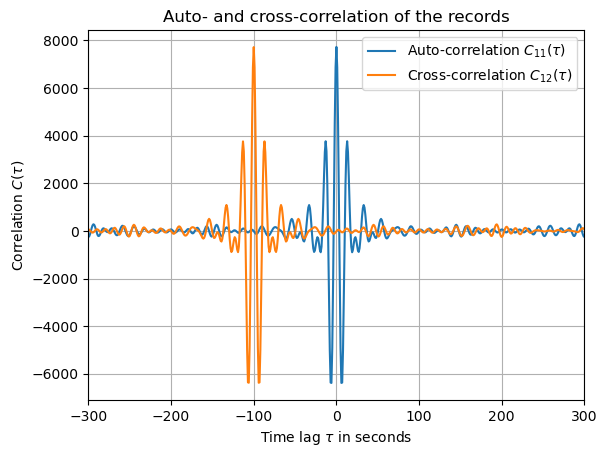

In [4]:
# Correlate the signals
autocorrelation = signal.correlate(station_1, station_1, mode="full")
crosscorrelation = signal.correlate(station_1, station_2, mode="full")

# Create the time axis
lags = np.arange(-n_samples + 1, n_samples) / sampling_rate

# Plot
fig, ax = plt.subplots()
ax.plot(lags, autocorrelation, label=r"Auto-correlation $C_{11}(\tau)$")
ax.plot(lags, crosscorrelation, label=r"Cross-correlation $C_{12}(\tau)$")

# Labels
ax.legend()
ax.set_xlim(-300, 300)
ax.set_xlabel(r"Time lag $\tau$ in seconds")
ax.set_ylabel(r"Correlation $C(\tau)$")
ax.set_title("Auto- and cross-correlation of the records")
ax.grid()

# Show
plt.show()

### 2.4. Cross-correlation of the synthetic seismograms for different azimuths

Now we will investigate the evolution of the cross-correlation function with respect to the azimuth of the single source. 

> __Question 6.__ With using the codes in the previous cells, calculate the cross-correlation function between the two station records for different azimuths of the single source. Plot the cross-correlation functions for different azimuths on the same plot. What is the impact of the azimuth of the single source on the cross-correlation function?

  0%|          | 0/100 [00:00<?, ?it/s]

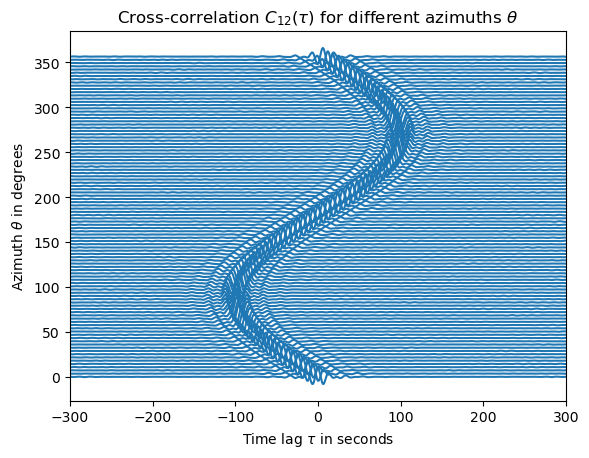

In [9]:
# Define the azimuthal source distribution (in degrees)
n_sources = 100
azimuths = np.linspace(0, 360, n_sources, endpoint=False)
amplitudes = np.ones_like(azimuths)

# Create the signal at both stations
source_records = noise.source_time_function(n_sources, n_samples, amplitudes)
times = np.arange(n_samples) / sampling_rate

# Filter the signal
source_records = noise.bandpass(source_records, fmin, fmax, sampling_rate)

cross_correlations = []
for source_record, azimuth in tqdm(zip(source_records, azimuths), total=n_sources):

    # Set signal for station 1
    record_1 = source_record

    # Set signal for station 2 by summing the sources with a time delay
    projection = np.sin(np.radians(azimuth))
    delay = projection * inter_station_distance / velocity
    record_2 = np.roll(source_record, int(delay * sampling_rate))

    # Correlate the signals
    xcorr = signal.correlate(record_1, record_2, mode="full")
    cross_correlations.append(xcorr)

# Plot correlation function with respect to azimuth
fig, ax = plt.subplots()

# Plot correlation functions
cross_correlations = np.array(cross_correlations)
cross_correlations /= np.max(np.abs(cross_correlations))
for source, azimuth in enumerate(azimuths):
    xcorr = cross_correlations[source]
    ax.plot(lags, xcorr * 10 + azimuth, color="C0")

# Labels
ax.set_ylabel(r"Azimuth $\theta$ in degrees")
ax.set_xlabel(r"Time lag $\tau$ in seconds")
ax.set_title(r"Cross-correlation $C_{12}(\tau)$ for different azimuths $\theta$")
ax.set_xlim(-300, 300)

# Show
plt.show()

A way of understanding the concept of cross-correlation for Green's function retrieval is the effect of _phase stationarity_. This implies that if you stack the cross-correlation functions for different azimuths, the phases that are related to azimuths located in the end-fire lobes will add up, while the phases that are related to azimuths located along direction perpendicular to the array will cancel out. 

> __Question 7.__ Stack the cross-correlation functions for different azimuths. What is the shape of the stacked cross-correlation function? What is the time lag $\tau$ corresponding to the maximum of the stacked cross-correlation function? What is the physical meaning of this time lag?

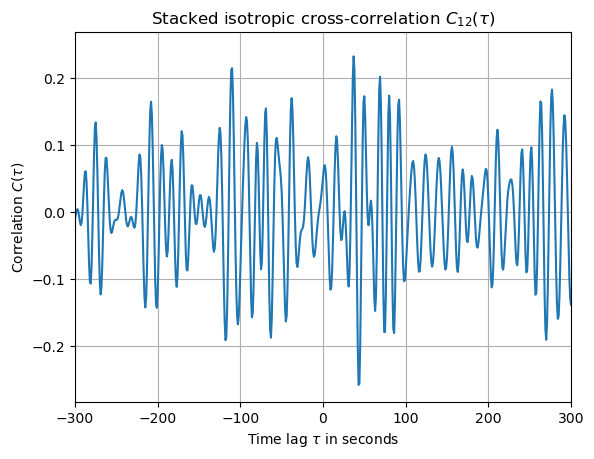

In [20]:
# Stack the correlation functions
stacked_correlation = np.sum(cross_correlations, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(lags, stacked_correlation)

# Labels
ax.set_xlabel(r"Time lag $\tau$ in seconds")
ax.set_ylabel(r"Correlation $C(\tau)$")
ax.set_title(r"Stacked isotropic cross-correlation $C_{12}(\tau)$")
ax.grid()
ax.set_xlim(-300, 300)

# Show
plt.show()

> __Question 8.__ Start again the experiment by changing the amplitude azimuthal distribution of the sources. For instance, you can consider a cosine distribution, i.e. $A(\theta) = |\cos(\theta)|$. What is the impact of the amplitude azimuthal distribution of the sources on the stacked cross-correlation function?

  0%|          | 0/100 [00:00<?, ?it/s]

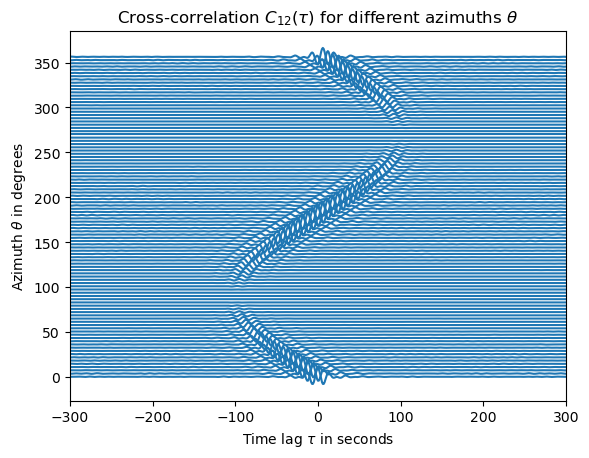

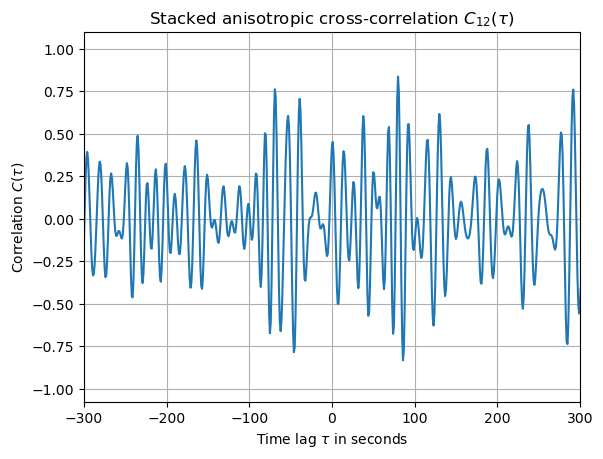

In [21]:
# Define the azimuthal source distribution (in degrees)
n_sources = 100
azimuths = np.linspace(0, 360, n_sources, endpoint=False)
amplitudes = np.abs(np.cos(np.radians(azimuths)))

# Create the signal at both stations
source_records = noise.source_time_function(n_sources, n_samples, amplitudes)
times = np.arange(n_samples) / sampling_rate

# Filter the signal
source_records = noise.bandpass(source_records, fmin, fmax, sampling_rate)

cross_correlations = []
for source_record, azimuth in tqdm(
    zip(source_records, azimuths), total=n_sources
):  
    # Set signal for station 1
    record_1 = source_record

    # Set signal for station 2 by summing the sources with a time delay
    projection = np.sin(np.deg2rad(azimuth))
    delay = projection * inter_station_distance / velocity
    record_2 = np.roll(source_record, int(delay * sampling_rate))

    # Correlate the signals
    xcorr = signal.correlate(record_1, record_2, mode="full")
    cross_correlations.append(xcorr)

# Plot correlation function with respect to azimuth
fig, ax = plt.subplots()

# Plot correlation functions
cross_correlations = np.array(cross_correlations)
cross_correlations /= np.max(np.abs(cross_correlations))
for source, azimuth in enumerate(azimuths):
    xcorr = cross_correlations[source]
    ax.plot(lags, xcorr * 10 + azimuth, color="C0")

# Labels
ax.set_ylabel(r"Azimuth $\theta$ in degrees")
ax.set_xlabel(r"Time lag $\tau$ in seconds")
ax.set_title(r"Cross-correlation $C_{12}(\tau)$ for different azimuths $\theta$")
ax.set_xlim(-300, 300)

# Show
plt.show()

# Stack the correlation functions
stacked_correlation = np.sum(cross_correlations, axis=0)

# Plot the stacked correlation function
stacked_correlation /= np.max(np.abs(stacked_correlation))

# Plot
fig, ax = plt.subplots()
ax.plot(lags, stacked_correlation)

# Labels
ax.set_xlabel(r"Time lag $\tau$ in seconds")
ax.set_ylabel(r"Correlation $C(\tau)$")
ax.set_title(r"Stacked anisotropic cross-correlation $C_{12}(\tau)$")
ax.grid()
ax.set_xlim(-300, 300)

# Show
plt.show()

### 2.5. Mixture of all sources

In real cases, the signals incoming from each source are not recorded separately as a function of the azimuth of the source. Instead, the signals are recorded as a function of time, and all sources are recorded simultaneously. Thanks to the linearity of the cross-correlation, we can still expect to retrieve the Green's function from the cross-correlation of the two station records.

> __Question 9.__ Using the previous codes, generate the synthetic signals recorded at the two stations for different azimuths of the single source, and stack them to get a mixture of all sources at once. Then, compute the cross-correlation of the two station records. How does it compare to the cross-correlation computed in the previous section? 

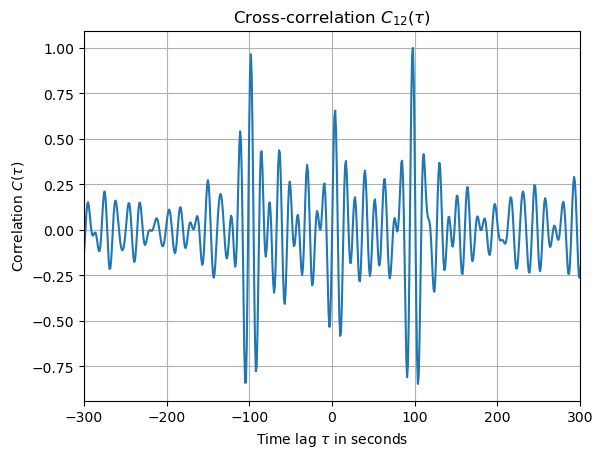

In [23]:
# Define the azimuthal source distribution (in degrees)
n_sources = 300
azimuths = np.linspace(0, 360, n_sources, endpoint=False)
amplitudes = np.ones_like(azimuths)

# Create the signal at both stations
source_records = noise.source_time_function(n_sources, n_samples, amplitudes)
times = np.arange(n_samples) / sampling_rate

# Filter the signal
source_records = noise.bandpass(source_records, fmin, fmax, sampling_rate)

# Set signal for station 1
record_1 = source_records.sum(axis=0)
record_2 = np.zeros_like(record_1)
for source_record, azimuth in zip(source_records, azimuths):
    projection = np.sin(np.deg2rad(azimuth))
    delay = projection * inter_station_distance / velocity
    record_2 += np.roll(source_record, int(delay * sampling_rate))

# Calculate the cross-correlation
xcorr = signal.correlate(record_1, record_2, mode="full")
xcorr /= np.abs(xcorr).max()

# Plot
fig, ax = plt.subplots()
ax.plot(lags, xcorr)

# Labels
ax.set_xlabel(r"Time lag $\tau$ in seconds")
ax.set_ylabel(r"Correlation $C(\tau)$")
ax.set_title(r"Cross-correlation $C_{12}(\tau)$")
ax.grid()
ax.set_xlim(-300, 300)

# Show
plt.show()

### 2.6. Getting rid of cross terms

When computing the cross-correlation from a mixture of signals, we need to get rid of the cross terms. This can be done by computing the cross-correlation between the two records from many instances of the experiment, and averaging the cross-correlation functions. From a signal processing viewpoint, this makes the strong assumption that the sources are stationary, i.e. that the source time functions are the same for all instances of the experiment, and that the sources are uncorrelated, i.e. that the source time functions are independent from each other.

> __Question 10.__ Using the previous codes, generate the synthetic signals recorded at the two stations for different azimuths of the single source, and stack them to get a mixture of all sources at once. Then, compute the cross-correlation of the two station records. Repeat this operation for many instances of the experiment, and average the cross-correlation functions. How does it compare to the cross-correlation computed in the previous section?

  0%|          | 0/10 [00:00<?, ?it/s]

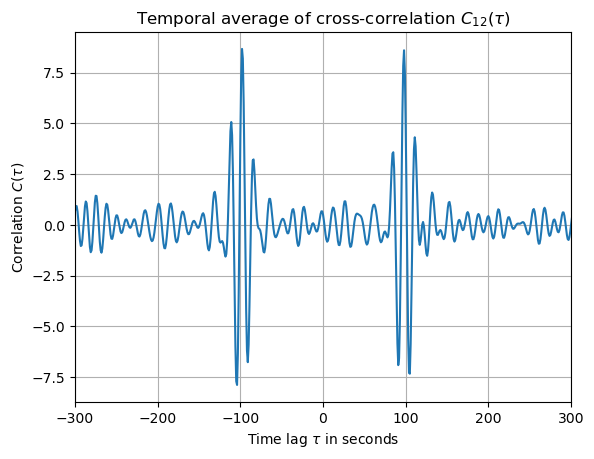

In [24]:
# Define the azimuthal source distribution (in degrees)
n_sources = 300
azimuths = np.linspace(0, 360, n_sources, endpoint=False)
amplitudes = np.ones_like(azimuths)

cross_correlations = np.zeros(2 * record_duration * sampling_rate - 1)

for experiment in tqdm(range(10)):
    # Create the signal at both stations
    source_records = noise.source_time_function(n_sources, n_samples, amplitudes)
    times = np.arange(n_samples) / sampling_rate

    # Filter the signal
    source_records = noise.bandpass(source_records, fmin, fmax, sampling_rate)

    # Set signal for station 1
    station_1 = source_records.sum(axis=0)

    # Set signal for station 2 by summing the sources with a time delay
    station_2 = np.zeros_like(station_1)
    for source_record, azimuth in zip(source_records, azimuths):
        projection = np.sin(np.radians(azimuth))
        delay = projection * inter_station_distance / velocity
        station_2 += np.roll(source_record, int(delay * sampling_rate))

    # Calculate the cross-correlation
    xcorr = signal.correlate(station_1, station_2, mode="full")
    xcorr /= np.abs(xcorr).max()
    cross_correlations += xcorr

# Plot
fig, ax = plt.subplots()
ax.plot(lags, cross_correlations)

# Labels
ax.set_xlabel(r"Time lag $\tau$ in seconds")
ax.set_ylabel(r"Correlation $C(\tau)$")
ax.set_title(r"Temporal average of cross-correlation $C_{12}(\tau)$")
ax.grid()
ax.set_xlim(-300, 300)

# Show
plt.show()

## 3. Application to real data

Now we will apply the previous concepts to real data. The goal of this notebook is to reproduce part of the results obatined in the paper [_High-Resolution Surface-Wave Tomography from Ambient Seismic Noise_, by Shapiro, et al. (2005)](https://www.science.org/doi/10.1126/science.1108339).

### 3.1. Data download

Firstly, we need to download the data from the seismic station MLAC and PHL from the _Southern California Seismic Network_ (CI). The data are available from the [IRIS Data Management Center](http://ds.iris.edu/ds/nodes/dmc/), we can be easily downloaded using the `obspy` package. The next cell allows to download the continuous data from the two stations for the year 2004, starting on the day 20/10/04, over four days.

> __Question 11.__ With your expertise in seismic data management, check the data availability for the two stations on the FDSN website. What are the coordinates of the two seismic stations? We here consider the vertical channel `LHZ`. What is the sampling rate of the data? Modify the code below to save the data in a `mseed` file. You can check the documentation of the `obspy` package to do so.

In [25]:
stream_duration_in_days = 4
start_date = "2004-10-20T00:00:00"
network = "CI"

# Connect to the IRIS database
client = Client("IRIS")

# Start and end times
starttime = obspy.UTCDateTime(start_date)
endtime = starttime + (stream_duration_in_days * 86400)

# Collect traces into a single stream
stream = client.get_waveforms(
    network=network,
    station="MLAC",
    location="*",
    channel="LHZ",
    starttime=starttime,
    endtime=endtime,
)
stream += client.get_waveforms(
    network=network,
    station="PHL",
    location="*",
    channel="LHZ",
    starttime=starttime,
    endtime=endtime,
)

# Save
for trace in stream:
    trace.write(trace.id + ".mseed", format="MSEED")

### 3.2. Data inspection

Before proceeding to the cross-correlation of the two station records, we need to inspect the data. The next cell allows to read the data from the `mseed` file and to plot the data. Remember that we expect the data to be stationary and uncorrelated. 

> __Question 12.__ Plot the raw data from the two stations and describe the obtained records. How is the data stationarity? 

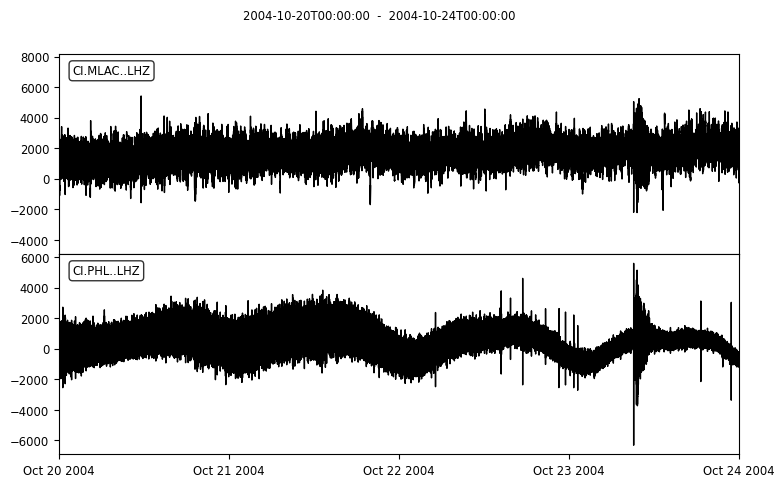

In [26]:
# Read
stream = obspy.read("*.mseed")

# Plot
stream.plot();

As explained in the previous sections, the data need to follow some requirements to be used for the cross-correlation. One key assumption is the equipartition of energy between the two stations. This implies two things: (1) the source spectra should be flat (and uncorrelated), and (2) the sources should be distributed isotropically in space.

> __Question 13.__ Compute the Fourier transform of the two station records and plot the amplitude spectrum. Does the amplitude spectrum look like what you would need for the cross-correlation? If not, what would you do to get the right amplitude spectrum?

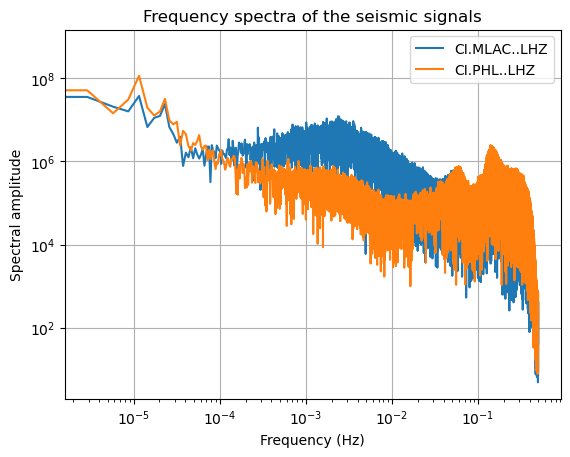

In [28]:
# Calculate the Fourier transform
spectra = list()
for trace in stream:
    # Calculate the Fourier transform
    trace_spectrum = np.abs(np.fft.rfft(trace.data))

    # Calculate the frequencies
    frequency = np.fft.rfftfreq(trace.data.size, d=trace.stats.delta)

    # Append to the list of spectra
    spectra.append(trace_spectrum)

# Plot
fig, ax = plt.subplots()
for i, spectrum in enumerate(spectra):
    ax.plot(frequency, spectrum, label=stream[i].id)

# Labels
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Spectral amplitude")
ax.set_title("Frequency spectra of the seismic signals")
ax.grid()
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

# Show
plt.show()

### 3.3. Data processing

One idea to attenuate the influence of sources or the natural color of the seismic noise is to filter the data in a frequency band of interest, and flatten the amplitude spectrum. The next cell allows to filter the data in a frequency band of interest and to plot the amplitude spectrum of the filtered data.

In order to do so, we can apply the following processing steps:

1. Detrend the data
2. Taper the data
3. Apply a bandpass filter to the data. We will here filter the data between 0.1 and 0.5 Hz, following the paper of Shapiro et al. (2005).
4. Stationarize the data. This stage is called _temporal normalization_, and can be done with the `normalize` function of the `noise` Python module.
5. Flatten the amplitude spectrum of the data. This stage is called _spectral whitening_, and can be done with the `whiten` function of the `noise` Python module.

> __Question 14.__ Apply the previous processing steps to the data, and between each step, plot the amplitude spectrum of the data and the time series. Describe the obtained results at each step. 

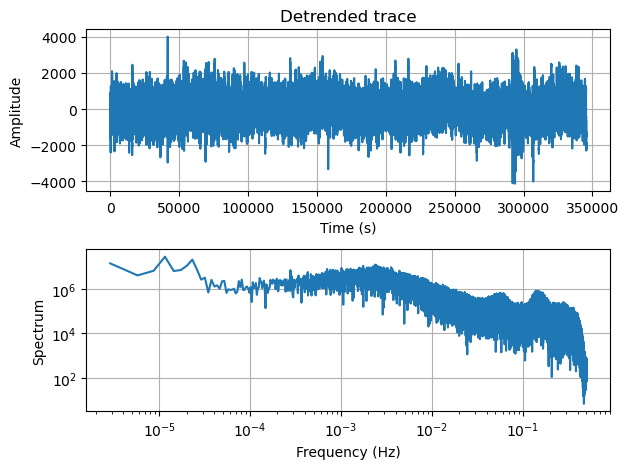

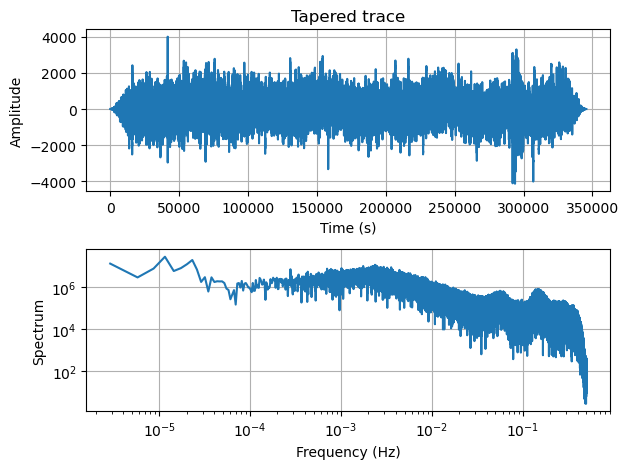

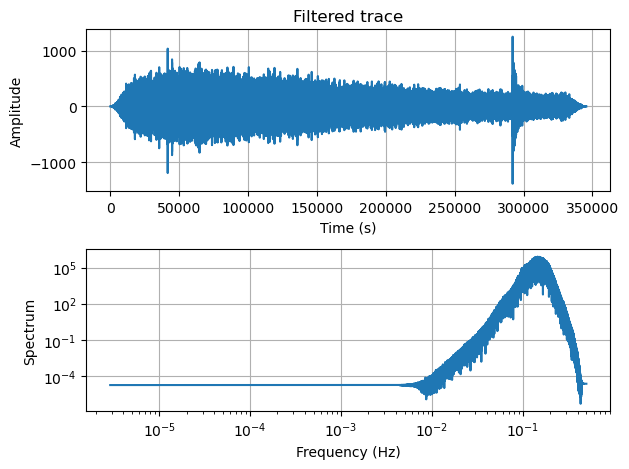

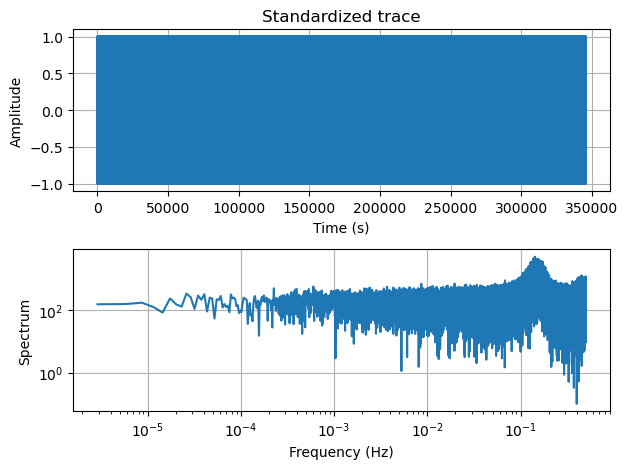

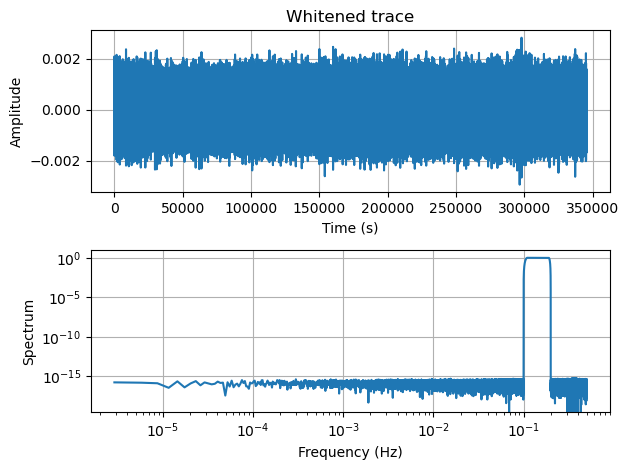

In [29]:
fmin, fmax = 0.1, 0.2

# First save the stream
stream_processed = stream.copy()

# Detrend
stream_processed.detrend("linear")
noise.plot_trace_and_spectrum(stream_processed[0], title="Detrended trace")

# Taper
stream_processed.taper(max_percentage=0.05)
noise.plot_trace_and_spectrum(stream_processed[0], title="Tapered trace")

# Filter
stream_processed.filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True)
noise.plot_trace_and_spectrum(stream_processed[0], title="Filtered trace")

# Standardize
for trace in stream_processed:
    trace = noise.normalize(trace)
noise.plot_trace_and_spectrum(stream_processed[0], title="Standardized trace")

# Whiten
for trace in stream_processed:
    trace = noise.whiten(trace, fmin, fmax)
noise.plot_trace_and_spectrum(stream_processed[0], title="Whitened trace")

### 3.4. Cross-correlation of the data

Now the data seems to be ready for the cross-correlation. The next cell allows to compute the cross-correlation of the two station records. We plot the cross-correlation function as a function of the time lag $\tau$.

> __Question 15.__ What is the shape of the cross-correlation function? Considering the distance between the two stations (that you can obtain from the coordinates of the two stations, see Question 10, and the `obspy.geodetics` package), what is the time lag $\tau$ corresponding to the maximum of the cross-correlation function? What can you conclude about the source distribution in California? Where are the sources located?

> __Question 16.__ From the cross-correlation function, can you estimate the seismic velocity in California between the two stations?

Estimated velocity: 1.98 km/s


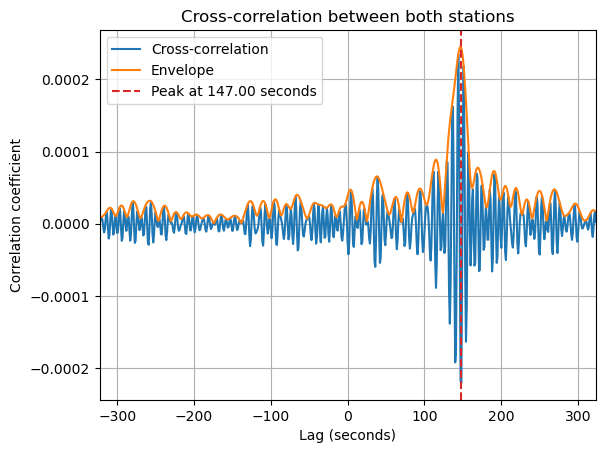

In [30]:
# Correlate
xcorr, lags = noise.crosscorrelate(stream_processed, ["MLAC", "PHL"], 7200)

# Distance
inv = client.get_stations(network=network, station="MLAC,PHL")
distance = (
    obspy.geodetics.locations2degrees(
        inv[0][0].latitude,
        inv[0][0].longitude,
        inv[0][1].latitude,
        inv[0][1].longitude,
    )
    * 111.19
)

# Approximate velocity
velocity = 2.7
expected_lag = distance / velocity

# Envelope with Hilbert transform
envelope = np.abs(signal.hilbert(xcorr))
peak_index = np.argmax(envelope)
peak_lag = lags[peak_index]
estimated_velocity = distance / peak_lag
print(f"Estimated velocity: {estimated_velocity:.2f} km/s")

# Plot
fig, ax = plt.subplots()
ax.plot(lags, xcorr, label="Cross-correlation")
ax.plot(lags, envelope, label="Envelope")
ax.axvline(
    peak_lag,
    color="C3",
    linestyle="--",
    label=f"Peak at {peak_lag:.2f} seconds",
)

# Labels
ax.set_xlabel("Lag (seconds)")
ax.set_ylabel("Correlation coefficient")
ax.set_xlim(-3 * expected_lag, 3 * expected_lag)
ax.set_title("Cross-correlation between both stations")
ax.legend()
ax.grid()

# Show
plt.show()

### 3.5. Comparison of the cross-correlation with an earthquake

In the previous section, we have used the cross-correlation of the two station records to estimate the seismic velocity in California. We can compare this result with the seismic velocity obtained from an earthquake that occurred 1998 close to the seismic station MLAC, of magnitude 5.1. The next cell allows to download the data from the earthquake and to plot the seismograms.

> __Question 17.__ Plot the seismograms from the earthquake. Considering that the earthquake occurred exactly at the station MLAC, what is the visually inferred seismic velocity? How does it compare to the seismic velocity obtained from the cross-correlation of the two station records? By modifying the code below, overlay the cross-correlation function on the seismograms and provide a quantitative comparison between the two seismic velocities. Remember that the derivative of the cross-correlation function is proportional to Green's function.

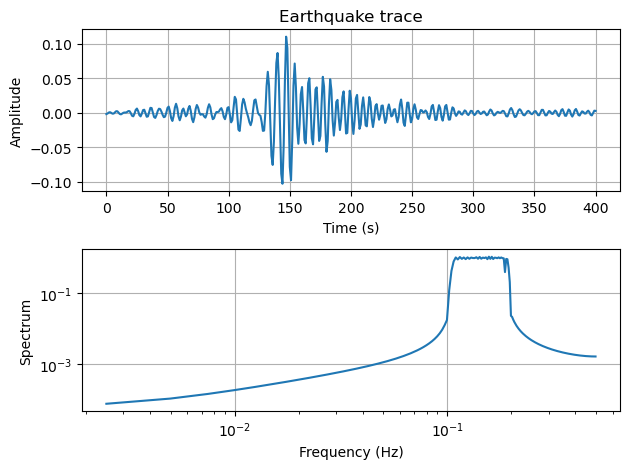

In [31]:
# Get the earthquake data
event_time = obspy.UTCDateTime(1998, 7, 15, 4, 53, 21, 0)
event_duration = 400

# Collect traces into a single stream
filename = "https://raw.github.com/ashimrijal/NoiseCorrelation/master/data/event.CI.PHL.LHZ.1998.196.1998.196.mseed"
stream_earthquake = obspy.read(filename)

# Apply a similar processing to allow for comparison
stream_earthquake.detrend("linear")
stream_earthquake.filter("bandpass", freqmin=0.1, freqmax=0.2, zerophase=True)
for trace in stream_earthquake:
    trace = noise.whiten(trace, 0.1, 0.2)

# Trim
stream_earthquake[0].trim(event_time, event_time + event_duration)

# Plot
noise.plot_trace_and_spectrum(stream_earthquake[0], title="Earthquake trace")

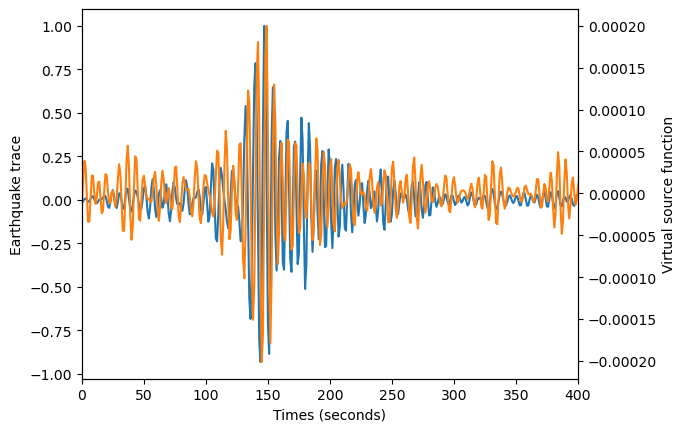

In [36]:
# Plot here
times_earthquake = stream_earthquake[0].times()
waveform_earthquake = stream_earthquake[0].data
waveform_earthquake /= np.abs(waveform_earthquake).max()

# Plot
fig, ax = plt.subplots()
ax.plot(times_earthquake, stream_earthquake[0].data)
ax_2 = ax.twinx()
ax_2.plot(lags[:-1], np.diff(xcorr), color="C1")

# Labels
ax.set_xlim(0, event_duration)
ax.set_xlabel("Times (seconds)")
ax.set_ylabel("Earthquake trace")
ax_2.set_ylabel("Virtual source function")

# Show
plt.show()

## 4. Perspectives

Let's summarize what we have done in this notebook. We have seen that the time derivative of the cross-correlation function is proportional to the Green's function between the two stations. Within a given frequency band, the cross-correlation function is dominated by the surface waves, so we could estimate the surface-wave velocity between the two stations within this frequency band.

The steps that would allow you to complete an entire scientific study are the following:

1. What is the velocity of the Rayleigh waves at other frequencies? Given that the waves attenuate with frequency, what do you see that could improve the signal-to-noise ratio of the retrieved Green's function?

2. You observed that the recovered cross-correlation function is not symmetric with respect to the time lag $\tau$, and expressed the reasons for this asymmetry. How would you correct this asymmetry, and how would you ensure in the future that the cross-correlation function is symmetric?

3. Given that California contains a lot of seismic stations, how would you then use this information to invert the surface-wave velocity in California?